# Ford GoBike Exploration
## by: Bassam Faramawi

## Preliminary Wrangling

> This document explores `Ford GoBike` dataset containing durattions and attributes for approximately 519,700 bike trips during 2017 covering San Francisco area.

In [14]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [15]:
# load in the dataset into a pandas dataframe, print statistics
gobike = pd.read_csv('2017-fordgobike-tripdata.csv')

In [16]:
# high-level overview of data shape and composition
print(gobike.shape)
print(gobike.dtypes)
print(gobike.head(10))
print(gobike.describe())

(519700, 15)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id             int64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id               int64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
dtype: object
   duration_sec                start_time                  end_time  \
0         80110  2017-12-31 16:57:39.6540  2018-01-01 15:12:50.2450   
1         78800  2017-12-31 15:56:34.8420  2018-01-01 13:49:55.6170   
2         45768  2017-12-31 22:45:48.4110  2018-01-01 11:28:36.8830   
3         62172  2017-12-31 17:31:10.6360  2018-01-01 10:47:23.5310   
4         43603  2017-12-31 14:23:14.0010  2018-01-01 02:29:57.5710   
5          9226  2017-

In [17]:
# Convert start_time' & 'end_time' columns to datetime type
gobike[['start_time', 'end_time']] = gobike[['start_time', 'end_time']].apply(pd.to_datetime,
                                                    infer_datetime_format=True, errors='coerce')

# Convert 'member_birth_year' column to integer type
gobike['member_birth_year'] = gobike['member_birth_year'].fillna(0).astype(np.int64)

# Create a new column of duration in minutes
gobike['duration_min'] = gobike.duration_sec / 60

# Create a new column of members age in 2017
gobike['member_age_2017'] = (2017 - gobike.member_birth_year).replace(2017, np.nan)

# Replace any member age above 112 with Nan value
gobike.loc[gobike['member_age_2017'] > 112, 'member_age_2017'] = np.nan

# Create a new column of member age categories
conditions = [(gobike['member_age_2017'] >= 16) & (gobike['member_age_2017'] <= 30), 
              (gobike['member_age_2017'] > 30) & (gobike['member_age_2017'] <= 45), 
              (gobike['member_age_2017'] > 45) & (gobike['member_age_2017'] <= 60),
              (gobike['member_age_2017'] > 60) & (gobike['member_age_2017'] <= 80),
              (gobike['member_age_2017'] > 80 ), (gobike['member_age_2017'] == np.nan)]
choices = ['16_30', '31_45', '46_60', '61_80', '80_112', np.nan]
gobike['age_group'] = pd.Categorical(np.select(conditions, choices), categories=choices[:-1], 
                                     ordered=True)

# Create a new column of month of trip
month_cats = ['June', 'July', 'August', 'September', 'October', 'November' ,'December']
gobike['month'] = pd.Categorical(gobike['start_time'].dt.month_name(), categories=month_cats[1:], 
                                 ordered=True)

# Create a new column of weekday of trip
dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
weekday_cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
gobike['weekday'] = pd.Categorical(gobike['start_time'].dt.dayofweek.map(dayOfWeek), 
                                   categories=weekday_cats, ordered=True)

# Create a new column of hour of trip
hour_cats = ['12 AM', '01 AM', '02 AM', '03 AM', '04 AM', '05 AM', '06 AM', '07 AM', '08 AM', 
             '09 AM', '10 AM', '11 AM', '12 PM', '01 PM', '02 PM', '03 PM', '04 PM', '05 PM', 
             '06 PM', '07 PM', '08 PM', '09 PM', '10 PM', '11 PM']
gobike['hour'] = pd.Categorical(gobike.start_time.dt.strftime('%I %p'), categories=hour_cats, 
                                ordered=True)


# Drop 'member_birth_year' and 'duration_sec'
gobike.drop(['member_birth_year', 'duration_sec'], axis=1, inplace=True)

# Re-arrange columns
gobike = gobike[['bike_id', 'duration_min', 'month', 'weekday', 'hour', 'start_time', 'end_time', 
                 'start_station_id', 'start_station_name', 'start_station_latitude', 
                 'start_station_longitude', 'end_station_id', 'end_station_name', 
                 'end_station_latitude', 'end_station_longitude', 'user_type', 
                 'member_gender', 'member_age_2017', 'age_group']]

# Convert some features type to category type
gobike[['user_type', 'member_gender', 'start_station_id', 'end_station_id', ]] = gobike[
    ['user_type', 'member_gender', 'start_station_id', 'end_station_id']].astype('category')

# Print new statistics
print(gobike.shape)
print(gobike.dtypes)
print(gobike.head(10))
print(gobike.describe())

(519700, 19)
bike_id                             int64
duration_min                      float64
month                            category
weekday                          category
hour                             category
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                 category
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                   category
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
user_type                        category
member_gender                    category
member_age_2017                   float64
age_group                        category
dtype: object
   bike_id  duration_min     month weekday   hour              start_time  \
0       96   1335.166667  December     Sun  04 PM 2017-12-31 16:57:39.654   
1       88   1313.333

### What is the structure of  the dataset?

> Here are 519700 bike trips in the dataset with 15 features (`bike_id`, `duration_min`, `month`, `weekday`, `hour`,  `start_time, end_time`, `start_station_id`,
  `start_station_name`, `start_station_latitude`, `start_station_longitude`, `end_station_id`, `end_station_name`, `end_station_latitude`,
  `end_station_longitude`, `user_type`, `member_gender`, `member_age_2017` and `age_group`). Some variables are numeric in nature, other are qualitiative.

### What is/are the main feature(s) of interest in the dataset?

> I'm most interested in figuring out features are what detecting the most age group and gender dealing with the bike rent system in the dataset and thair ridership during the hours of day. I aslo interseted in features what help to predict how does ridership differ in terms of month of the year?,  Which month has the highest ridership? and does the ratio of Subscriber trips to Customer trips change depending on the month.


### What features in the dataset do think will help support the investigation into the feature(s) of interest?

>   `member_age_2017` & `member_gender` features are direct related to the age group and gender of groups.

>   `duration_min` feature has the strongest information about the trip durations in minutes.

>   `user_type` feature gives direct information about the type of user is a subscriber or a customer.

>   `month` & `weekday` & `hour` features have the clearest information about date/time distribution of trips.

## Univariate Exploration

> I will be looking at trip duration:

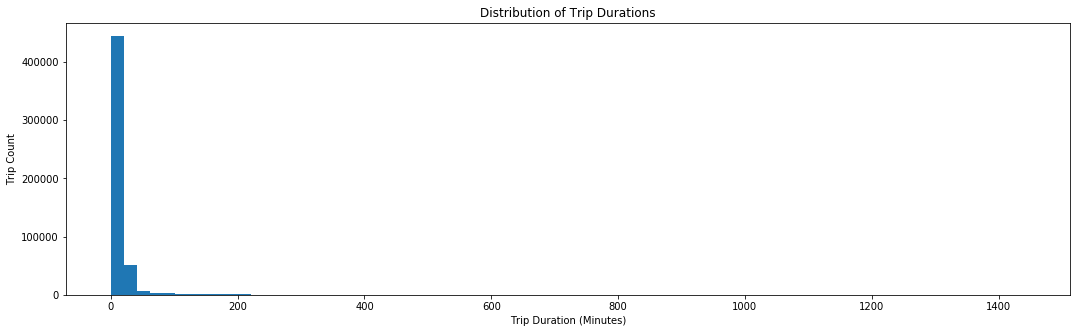

In [60]:
# Start with a standard hist plot
binsize = 20
bins = np.arange(gobike['duration_min'].min(), gobike['duration_min'].max()+binsize, binsize)

plt.figure(figsize=[18, 5])
plt.hist(data = gobike, x = 'duration_min', bins = bins)
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Trip Count')
plt.title('Distribution of Trip Durations');

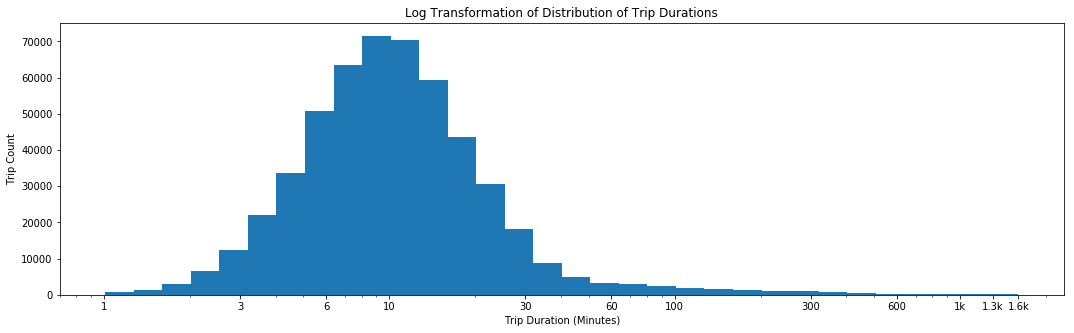

In [61]:
# there's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.1
bins = 10 ** np.arange(np.log10(1.01), np.log10(gobike['duration_min'].max())+log_binsize, log_binsize)

plt.figure(figsize=[18, 5])
plt.hist(data = gobike, x = 'duration_min', bins = bins)
plt.xscale('log')
plt.xticks([1, 3, 6, 10, 30, 60, 100, 300, 600, 1000, 1300, 1600], 
           [1, 3, 6, 10, 30, 60, 100, 300, 600, '1k', '1.3k', '1.6k'])
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Trip Count')
plt.title('Log Transformation of Distribution of Trip Durations');

`duration_min` has a long-tailed distribution, with a lot of trips on the short durations al the left end, and few on the medium and high duration at the right end. When plotted on a log-scale, the duration distribution looks roughly normal, with one peak between 6 and 20 minutes. 

Next, lets look at `member_age`:

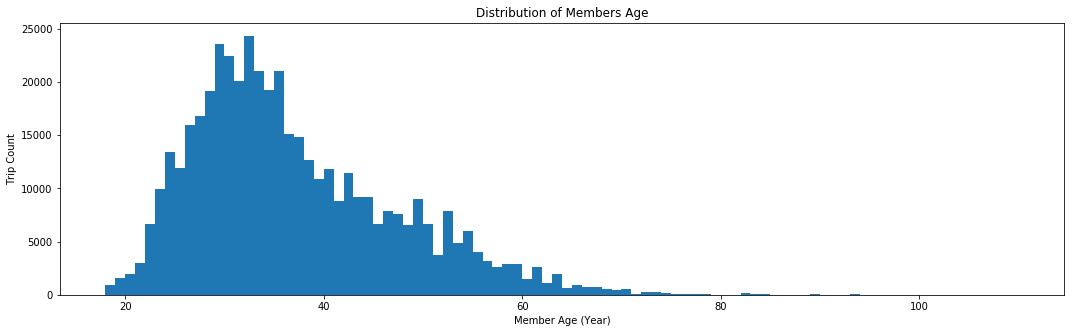

In [62]:
# Plot hist of member_age
binsize = 1
bins = np.arange(18, gobike['member_age_2017'].max()+binsize, binsize)

plt.figure(figsize=[18, 5])
plt.hist(data = gobike, x = 'member_age_2017', bins = bins)
plt.xlabel('Member Age in 2017 (years)')
plt.xlabel('Member Age (Year)')
plt.ylabel('Trip Count')
plt.title('Distribution of Members Age');

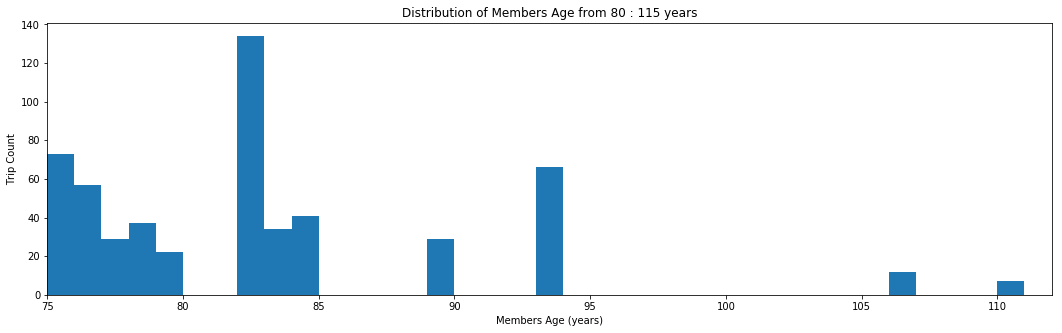

In [63]:
# There is a tail at the right end between 75 and 112 years, so lets spot it
binsize = 1
bins = np.arange(75, 112+binsize, binsize)

plt.figure(figsize=[18, 5])
plt.hist(data = gobike, x = 'member_age_2017', bins = bins)
plt.xlim(75, 112)
plt.xlabel('Members Age (years)')
plt.ylabel('Trip Count')
plt.title('Distribution of Members Age from 80 : 115 years');

In the case of Member Age, the small bin size proves very illuminating. This is a semi-normal distribution with a peak between 25 and 35 years old and a tail on the right. Note that most of trips is at the youth side (left) and few at the old side (right).

I'll now move on to `member_gender` variable in the dataset:

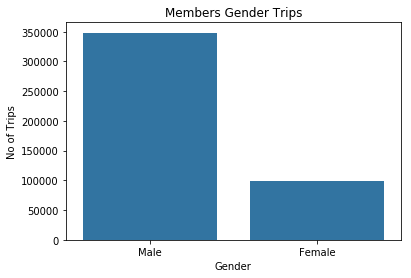

In [64]:
# Plot a the Members Gender Trips (excluding 'Other' group from member_gender group)
sb.countplot(data=gobike, x='member_gender', order=gobike.member_gender.value_counts().iloc[:2].index
             ,color=sb.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('No of Trips')
plt.title('Members Gender Trips');

It's clear the high space between male members trips and female members ones.

Finally lets look at the distribution of trips during hours of the day:

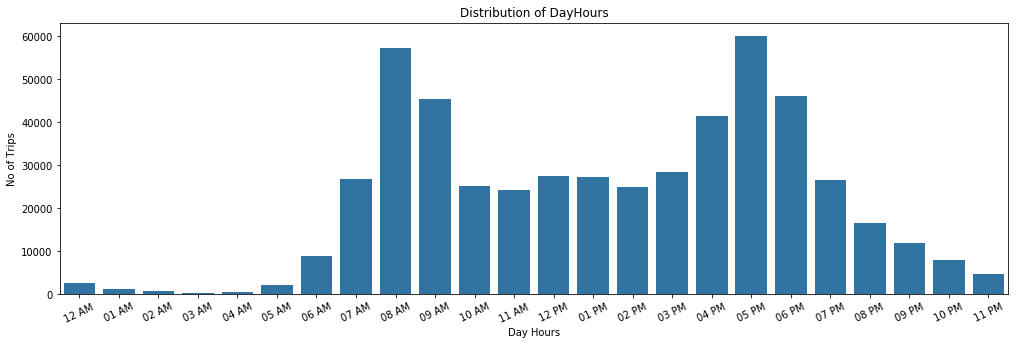

In [71]:
# Bar plot of trips during day hours
plt.figure(figsize=(17,5))
sb.countplot(data=gobike, x='hour', color=sb.color_palette()[0])
plt.xticks(rotation=25)
plt.xlabel('Day Hours')
plt.ylabel('No of Trips')
plt.title('Distribution of DayHours');

The shape has tow spikes at both sides with little peak in between. The trips prisk at both (8-9)AM and (5-6)PM (which is rush hours) with moderate activity at mid-day and few activity at the night.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The `duration_min` variable took on a large range of values, so I looked at the data using a log transform. Under the transformation, the data looked normal distributed, with one peak between  6 𝑎𝑛𝑑 20 minutes. The `member_age_2017` is semi-normal distributed with a peak between 25 and 35 years old and a tail on the right.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> When investgating the `member_age_2017` veriable, number of outliers points were identified. There is unbelievable (such as 1886 which his age in 2017 is 131 years), and by returning to this [link] identifying this points be wrong entried so this points should imputated.Also, There are incomplete data of month June in the `month` feature that the data include few days from this month, so i will exclude it in explorations related to month calculations to get strong evidence of it . Finally, There is some entries doesn't have gender type information in the `member_gender` feature, so i will exclude it when treating with explorations related to the feature.

## Bivariate Exploration

> To start off with, I want to look at the activity of customers and subscribers during the day hours. This could be depicted by ploting the relation between `user_type` & `hour` features in the data.

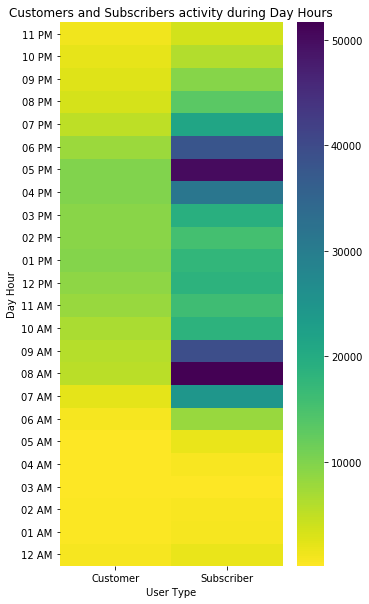

In [72]:
# Plot a heat map of user_type and hour categories veriable
heat_type_counts = gobike.groupby(['user_type', 'hour']).size()
heat_type_counts = heat_type_counts.reset_index(name = 'count')
heat_type_counts = heat_type_counts.pivot(index = 'hour', columns = 'user_type', values = 'count')
plt.figure(figsize=(5, 10))
ax = sb.heatmap(heat_type_counts, cmap='viridis_r')
plt.yticks(rotation=0)
plt.xlabel('User Type')
plt.ylabel('Day Hour')
plt.title('Customers and Subscribers activity during Day Hours')
ax.invert_yaxis();

Giving the expected activity of trips at rush hours(darkest points), there is much activity in the subscribers side at this hours more than the customers side. In the early hours of the morning and afternoon, subscribers ride the bike on a daily basis more than rest of the day. This may be understood to be due to the reliance on the bike to some subscribers as a means of going to work and back.

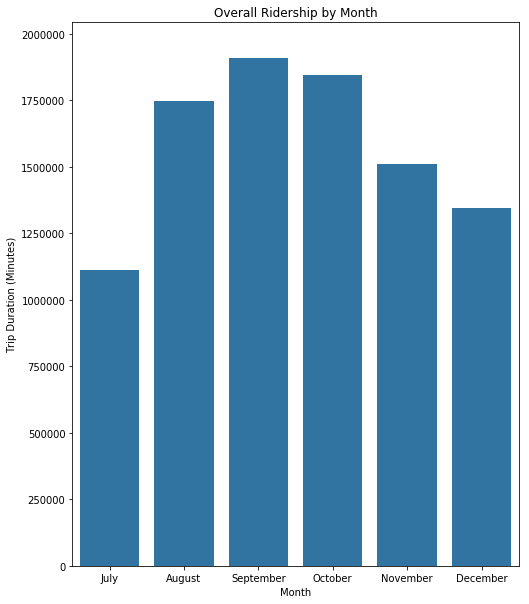

In [18]:
# Plot bar plot of trip durations among months (excluding June data due to incompelete of its data)
plt.figure(figsize=[8, 10])
sb.barplot(data=gobike, x='month', y='duration_min', color = sb.color_palette()[0], 
           errwidth=0, estimator=sum)
plt.xlabel('Month')
plt.ylabel('Trip Duration (Minutes)')
plt.title('Overall Ridership by Month');

Biking ridership begin to increase in a monthly manner with summer months until the end of the summer (September) and then begin to decrease thereafter with autumn months. This may be due to the nature of the weather.

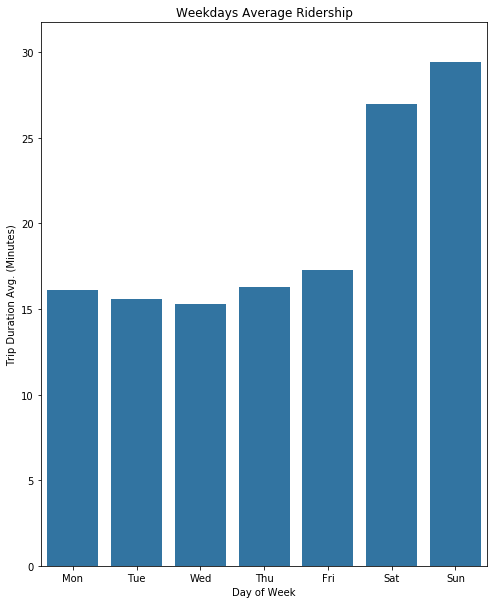

In [76]:
# Plot bar plot of  average trip durations among weekdays
plt.figure(figsize=[8, 10])
sb.barplot(data=gobike, x='weekday', y='duration_min', color = sb.color_palette()[0], 
          errwidth=0)
plt.xlabel('Day of Week')
plt.ylabel('Trip Duration Avg. (Minutes)')
plt.title('Weekdays Average Ridership');

By the same way there is a space between the ridership during weekends and the ridership during workdays.

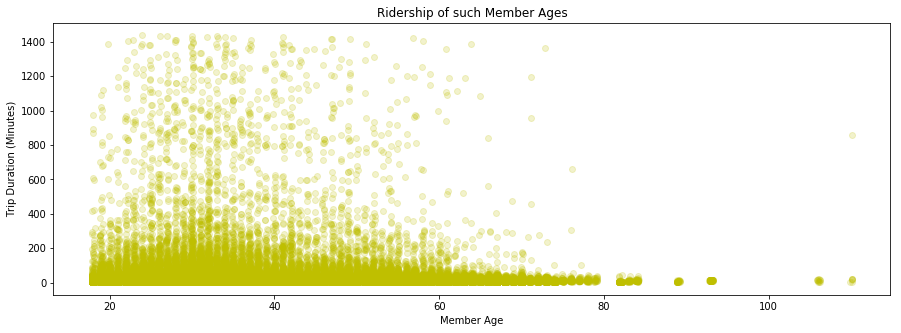

In [80]:
# Plot a scatter plot of trip durations and member ages
plt.figure(figsize=[15, 5])
gobike_filtered = gobike[gobike['member_age_2017'] > 0]
sb.regplot(data= gobike_filtered, x='member_age_2017', y='duration_min', 
           scatter_kws={'alpha':1/5}, fit_reg=False, x_jitter=0.2, y_jitter=0.2, color='y')
plt.xlabel('Member Age')
plt.ylabel('Trip Duration (Minutes)')
plt.title('Ridership of such Member Ages');

It is clear that the relationship between the age of the members and duration of the trip is negative. The older the age, the shorter the trip and vice versa. It is noted that there is an intensity in short trips less than 20 minutes and also there is a density of trips among the young people under the age of 40 years.

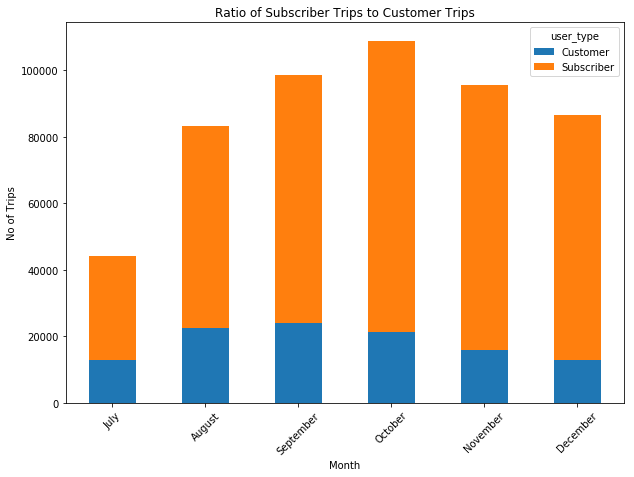

In [85]:
# Plot stacked bar plot of ratio of Subscriber Trips to Customer Trips
groupped = gobike.groupby(['month', 'user_type']).size().reset_index()
groupped = groupped[groupped['month'] != 'June']
groupped = groupped.pivot(index='month', columns='user_type', values=0)
groupped.plot(kind='bar', stacked=True, figsize=(10,7))
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('No of Trips')
plt.title('Ratio of Subscriber Trips to Customer Trips');

The ratio of subscribers to customers increases with the summer months to reach its peak in September(which has the most of orange to blue ratio) and then return to decline during the autumn months.

### Talk about some of the relationships  observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> `duration_min` had a surprisingly high amount of negative correlation with the `member_age_2017`. There was also an interesting relationship observed between `duration_min` and the categorical features. For all of `month`, `weekday` and `hour` `month`, have a direct effect on the ridershp (sum of `duration_min`) associated. For `month`, ridership is with summer season increasing steady, inverse of that in autumn one so ridership is increasing. For `weekday`, the ridership in weekends is more than in workdays. For `hour`, the ridership increasing in rush hours and a moderate ridership between them and decresing in night.



### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> For `user_type` The subscribers trips partition is more than the customer one. This is be more clear when connecting with `hour` feature in terms of hours of the day found that the subscribers have the largest share of trips at morining and afternoon.


## Multivariate Exploration

> The main thing I want to explore in this part of the analysis is how the tow quantitiave measures `duration_min` & `member_age` play into the relationship between three categorical feauters `member_gender` & `age_group`vand `user_type`.

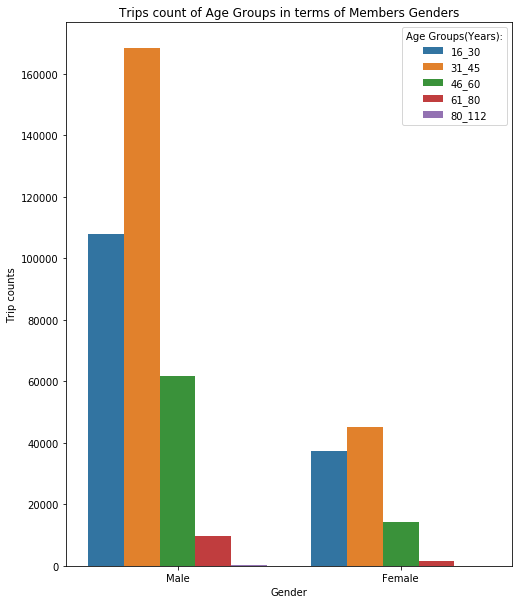

In [133]:
# Plot a clustered bar chart of trip counts with age group in terms of Members Genders (excluding specified gender)
gender_order = gobike.member_gender.value_counts().iloc[:2].index
age_group_order =  ['16_30', '31_45', '46_60', '61_80', '80_112']

plt.figure(figsize=[8, 10])
sb.countplot(data=gobike, x='member_gender', hue='age_group', order=gender_order, hue_order=age_group_order)
plt.title('Trips count of Age Groups in terms of Members Genders')
plt.xlabel('Gender')
plt.ylabel('Trip counts')
plt.legend(title='Age Groups(Years):');

The users between 31 and 45 years have the most frequency of rent trips for both male and female users. The least frequancy of trips is of users between 80 and 112 years. But in overall, males have more trips frequancy than females.

C:\Users\Bassam\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


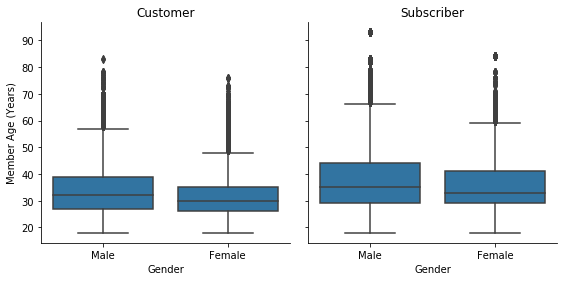

In [88]:
g = sb.FacetGrid(data = gobike, col = 'user_type', size = 4)
g.map(sb.boxplot, 'member_gender', 'member_age_2017', order=
      gobike.member_gender.value_counts().iloc[:2].index)
axes = g.axes.flatten()
axes[0].set_title("Customer")
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Member Age (Years)')
axes[1].set_title("Subscriber")
axes[1].set_xlabel('Gender');

The mean of ages of male customers is (33 y) and is near the mean of ages of male subscibers (35 y), and this the case for female customers and female subscribers. Also both of the subscribers genders have wider rang of ages than the customers genders.

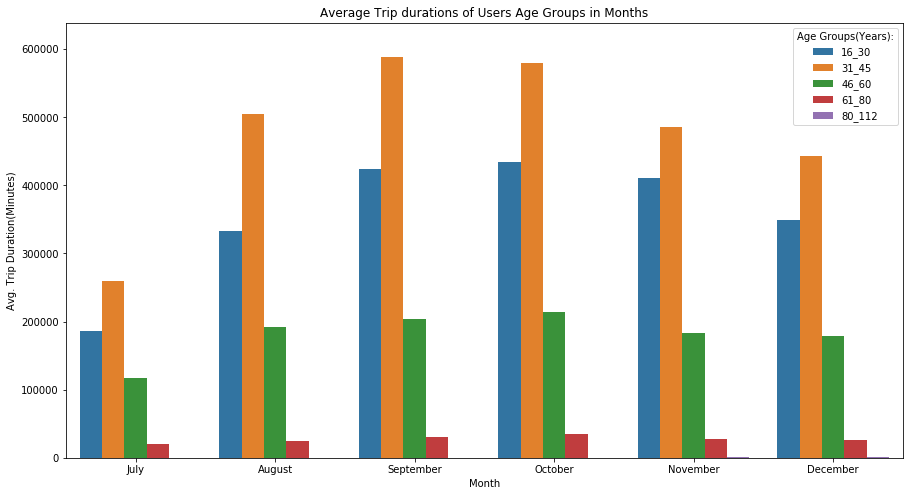

In [19]:
# Plot clusterd bar plot of Average Trip durations of Users Age Groups in Months
plt.figure(figsize=(15,8))
ax = sb.barplot(data=gobike, x='month', y='duration_min', hue='age_group',
                errwidth=0, estimator=sum)
plt.xlabel('Month')
plt.ylabel('Avg. Trip Duration(Minutes)')
plt.title('Average Trip durations of Users Age Groups in Months')
plt.legend(title='Age Groups(Years):');

The users between 31 and 45 years has the most average ridership for both male and female users. The least average ridership  is of user between 80 and 112 years. But in overall, The most  Average of ridership is in September.

### Talk about some of the relationships  observed in this part of the investigation. Were there features that strengthened each other in terms of looking at  feature(s) of interest?

> I extended my investigation of `duration_min` against `age_group` in this section by looking at the impact of the `month` categorical feature. The multivariate exploration here showed that the most ridership during all the year is done by the guys between 31y and 45y age, and the least ridershp done by old guys of between 80y to 112y age. 

### Were there any interesting or surprising interactions between features?

> Looking back on the point plots, the mean of ages in both subscribers and customers users in terms of gender doesn't differ much and about 30y to 35y old.